

# Convolutional Neural Nets for Image Recognition

# 1. Introduction

This tutorial is an introduction to Convolutional Neural Networks using TensorFlow 2.x Keras API. The dataset that we will work it is the Cifar10 dataset, a dataset of images from 10 different classes, and we will use a Sequential CNN to identify the class of an image.

This model reaches ~80% accuracy.

To prepare our notebook, run the next cell to import the necessary packages. Change the accelerator from ```None``` to ```GPU``` on the right.

In [16]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

print(tf.__version__)


2.15.0


# 2. Data Preprocessing

Before building any ML model, it is important to preprocess the data. In fact, data preprocessing will generally take up the most time in any ML pipeline. The following module goes over the steps to preprocess the CIFAR10 dataset for our purposes.

## 2.1 Load Data

Our first step is to load the data and divide it into a training and testing dataset. The CIFAR10 dataset can be downloaded directly from TensorFlow and has already been divided. Run the next cell to import the data.

``` x_train ``` is the dataset of 32x32 color images of objects that the model will be trained on.

```y_train``` is the dataset of labels that correspond to ```x_train```.

``` x_test ``` is the dataset of 32x32 color images of objects that the model will be tested on.

```y_test``` is the dataset of labels that correspond to ```x_test```.

Classes:
    0. airplane
    1. automobile
    2. bird
    3. cat
    4. deer
    5. dog
    6. frog
    7. horse
    8. ship
    9. truck

In [17]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [18]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [19]:

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Run the following code to see how many images are in each class. We see that each class has 5000 images. Having an even distribution of images is helpful for our model as it will have enough images to learn about the features for each class.

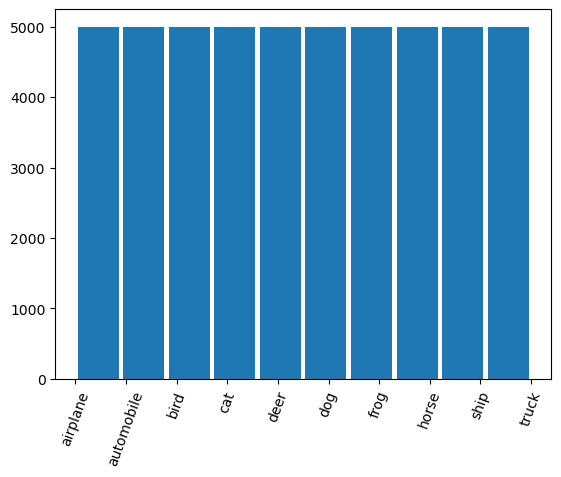

In [20]:

plt.hist(y_train,rwidth=0.9);
plt.xticks(np.arange(10),labels=classes,rotation=70);

## 2.2 Check for NaN Values

In [21]:
np.isnan(x_train).any()

False

In [22]:
np.isnan(x_test).any()

False

There are no NaN values in our dataset. There is no need to preprocess the data to deal with NaN's.

## 2.3 Normalization and Reshaping

Since the values in our ```x_train``` dataset are 32x32 color images, our input shape must be specified so that our model will know what is being inputed.

The first convolution layer expects a single 50000x32x32x3 tensor instead of 50000 32x32x3 tensors.

Models generally run better on normalized values. The best way to normalize the data depends on each individual dataset. For the CIFAR10 dataset, we want each value to be between 0.0 and 1.0. As all values originally fall under the 0.0-255.0 range, divide by 255.0.

Run the following cell to define the ```input_shape``` and to normalize and reshape the data.

In [23]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

## 2.4 Label Encoding

The labels for the training and the testing dataset are currently categorical and is not continuous. To include categorical dataset in our model, our labels should be converted to one-hot encodings.

For example, ```2``` (bird) becomes ```[0,0,1,0,0,0,0,0,0,0]``` and ```7``` (horse) becomes ```[0,0,0,0,0,0,0,1,0,0]```.

Run the following cell to transform the labels into one-hot encodings

In [24]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [25]:
y_train[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)>

## 2.5 Visualize Data

Run the following cell to visualize an image in our dataset.

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)


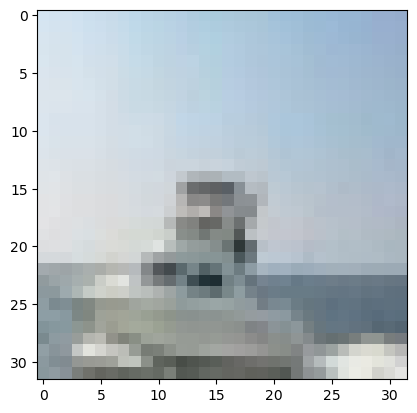

In [26]:
plt.imshow(x_train[100])
print(y_train[100])

The image is an image of a ship. The one-hot encoding vector holds the value of the ship class.


# 3. CNN

In this module, we will build our CNN model.

## 3.1 Define the Model Architecture

**Run the following cell to define ```batch_size```, ```num_classes```, and ```epochs```. Try changing the values and test how different values affect the accuracy of the CNN model.**

In [27]:
num_classes = 10


Run the following cell to build the model. The model contains various layers stacked on top of each other. The output of one layer feeds into the input of the next layer.

Conv2D layers are convolutions. Each filter (32 in the first two convolution layers and 64 in the next two convolution layers) transforms a part of the image (5x5 for the first two Conv2D layers and 3x3 for the next two Conv2D layers). The transformation is applied on the whole image.

MaxPool2D is a downsampling filter. It reduces a 2x2 matrix of the image to a single pixel with the maximum value of the 2x2 matrix. The filter aims to conserve the main features of the image while reducing the size.

Dropout is a regularization layer. In our model, 25% of the nodes in the layer are randomly ignores, allowing the network to learn different features. This prevents overfitting.

```relu``` is the rectifier, and it is used to find nonlinearity in the data. It works by returning the input value if the input value >= 0. If the input is negative, it returns 0.

Flatten converts the tensors into a 1D vector.

The Dense layers are an artificial neural network (ANN). The last layer returns the probability that an image is in each class (one for each digit).

As this model aims to categorize the images, we will use a ```categorical_crossentropy``` loss function.

### 3.1.1 Two layers

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, 5, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 6, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            loss='categorical_crossentropy', metrics=['acc'])

### 3.1.2:  Four layers

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 5, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
            loss='categorical_crossentropy', metrics=['acc'])


## 3.2 Gradient Descent

Define the batch size and number of epochs for mini-batch stochastic gradient descent

In [29]:
batch_size = 32
epochs = 2


## 3.3 Fit the Training Data

Testing the model on a validation dataset prevents overfitting of the data. The default is a 10% validation and 90% training split.

In [30]:
history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs)

Epoch 1/2
1563/1563 [==============================] - 71s 45ms/step - loss: 1.8762 - acc: 0.3108
Epoch 2/2
1563/1563 [==============================] - 75s 48ms/step - loss: 1.5431 - acc: 0.4385


# 4. Evaluate the Model

## 4.1 Loss and Accuracy Curves

Run the following cell to evaluate the loss and accuracy of our model

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

The accuracy increases over time and the loss decreases over time.


If you run the model for ~50 epochs, the accuracy of our validation set seems to slightly decrease towards the end even thought our training accuracy increased. Running the model for even more epochs might cause our model to be susceptible to overfitting.

## 4.2 Predict Results


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

Our model runs pretty well, with an accuracy of ~80% on our testing data.

## 4.3 Confusion Matrix

Run the following cell to compute our confusion matrix using TensorFlow.

In [ ]:
# Predict the values from the validation dataset
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred,axis = 1)
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_classes)

Run the following cell to plot the confusion matrix. We see that our model classifies frogs pretty well, with 900 out of the 1000 frog images heving been classified correctly. We can also see that there is relatively high confusion between cats and dogs.

In [ ]:
plt.figure(figsize=(12, 9))
ax=plt.gca()
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_classes,cmap=plt.cm.Blues,normalize='true',ax=ax);
